# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [ ]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code'))
from distcl import distcl

## Load Data

In [ ]:
# Load Data
data = pd.read_csv("data/two_windturbine.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,800,0,8.0,270.0,0.06,1753.954459,615.070589,2369.025048
1,800,200,8.0,270.0,0.06,1753.954459,1751.593411,3505.547870
2,800,400,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
3,800,600,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
4,900,0,8.0,270.0,0.06,1753.954459,694.023084,2447.977544


# Train NN and generate constraints

In [ ]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [72]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

model, preds_test, sd_test, y_test = cl_tool.train(n_hidden=5, n_nodes=40, iters=500, drop=0.05, learning_rate=1e-4)

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=4, out_features=40, bias=True)
    (1-4): 4 x Linear(in_features=40, out_features=40, bias=True)
  )
  (output_mean_layer): Linear(in_features=40, out_features=1, bias=True)
  (output_sd_layer): Linear(in_features=40, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-4): 5 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 264480.25
NN fitting process finished with a validation GAUSSIANNLL loss of -0.06832931935787201 in epoch 499


In [73]:
cons = cl_tool.constraint_build(model)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,...,node_30,node_31,node_32,node_33,node_34,node_35,node_36,node_37,node_38,node_39
0,-0.063416,0,0,-0.003743,0.268222,-0.434444,-0.416396,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.066919,0,1,-0.192577,0.134079,0.006301,0.426742,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.448675,0,2,-0.044372,0.132306,-0.151107,-0.098283,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.431719,0,3,-0.477674,-0.331141,-0.206112,0.018522,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.034991,0,4,0.197668,0.300011,-0.379991,-0.270015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,-0.151068,4,37,0.076426,-0.008989,-0.136381,0.081812,-0.063712,0.001483,-0.053548,...,0.003401,0.095299,0.105897,0.014411,-0.009937,0.050876,0.029782,-0.010202,0.119624,0.136482
38,0.053470,4,38,-0.098261,0.146415,-0.040009,0.034017,0.141915,-0.071722,0.069254,...,-0.038157,0.047157,-0.157658,0.020106,-0.090512,0.011244,0.097442,0.131240,-0.035292,0.166748
39,-0.026251,4,39,-0.002149,-0.091001,0.073353,0.006848,-0.119057,0.106334,0.159643,...,0.067091,0.020087,-0.069657,-0.060870,0.096460,-0.128954,-0.047198,-0.153831,-0.085006,0.013622
0,0.115809,5,0,0.099068,0.065816,0.116695,0.011022,-0.022752,0.005957,0.106187,...,-0.142532,0.033556,0.054344,0.171576,0.137812,-0.076218,0.046482,0.016204,0.077469,-0.089161


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

contextual_sample = data[["x_turb2", "y_turb2", "wind_speed", "wind_direction"]].iloc[[0]]
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # learned variables (demand)

model.power = pyo.Var(within=pyo.Reals) # saving power per scenario


# obj function 
def obj_expression(model):
    return model.power
model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model):
    return model.power == model.y['power', 1, 'mean']
model.const_power = pyo.Constraint(rule=power)

#constraint for fixing contextual information
def fix_vars(model,x_ind):
    if x_ind=='x_turb2':
        return pyo.Constraint.Skip
    if x_ind=='y_turb2':
        return pyo.Constraint.Skip
    else:
        return model.x[x_ind] == contextual_sample.loc[0,x_ind]
model.const_fix_vars = pyo.Constraint(model.var_ind, rule=fix_vars)

# range limits for x_turb2 and y_turb2
model.x_turb2_lb = pyo.Constraint(expr=800 <= model.x['x_turb2'])   # Lower bound
model.x_turb2_ub = pyo.Constraint(expr=model.x['x_turb2'] <= 5000)  # Upper bound

model.y_turb2_lb = pyo.Constraint(expr=0 <= model.x['y_turb2'])     # Lower bound
model.y_turb2_ub = pyo.Constraint(expr=model.x['y_turb2'] <= 600)   # Upper bound


# ## min distance 
# # Define constraints if any (for example, minimum distance between turbines)
# def distance_constraint(model):
#     return ((model.x_turb2 - 0)**2 + (model.y_turb2 - 0)**2) >= 400**2 
# model.distance_constraint = Constraint(rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed(opt_model=model, constaints=cons, outcome='power', deterministic = True)


1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')


In [75]:

# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmpifufdyt2.pyomo.lp
Reading time = 0.02 seconds
x1: 610 rows, 409 columns, 14212 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 610 rows, 409 columns and 14212 nonzeros
Model fingerprint: 0x53e44243
Variable types: 209 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 21 rows and 14 columns
Presolve time: 0.03s
Presolved: 589 rows, 395 columns, 13733 nonzeros
Variable types: 199 continuous, 196 integer (196 binary)

Root relaxation: o

In [ ]:
# print optimization results
print("\nOptimization Results:")

# Print x variables (contextual features and decision variables)
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")



Optimization Results:

Contextual/Decision Variables (x):
wind_direction: 270.0
wind_speed: 8.0
x_turb2: 5000.0
y_turb2: 600.0

Generated Power: 0.4304190995810243


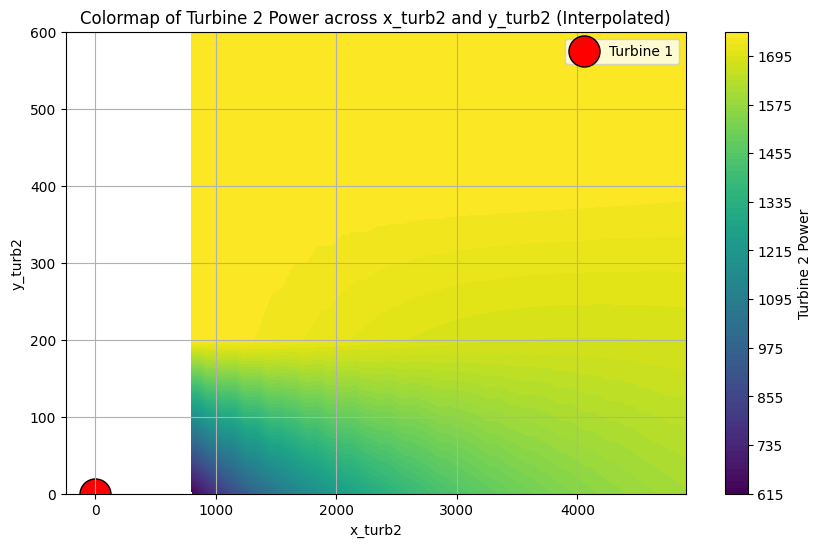

In [85]:
from scipy.interpolate import griddata


# Visualize the results

# Perform linear interpolation to make the map continuous

# Colormap with interpolation
x = data['x_turb2']
y = data['y_turb2']
z = data['turbine2_powers']
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

plt.figure(figsize=(10, 6))
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
plt.colorbar(label='Turbine 2 Power')

# Mark the position of wind turbine one
plt.scatter(0, 0, color='red', label='Turbine 1', s=500, edgecolor='black')
plt.legend()

# cosmetics 
plt.xlabel('x_turb2')
plt.ylabel('y_turb2')
plt.title('Colormap of Turbine 2 Power across x_turb2 and y_turb2 (Interpolated)')
plt.grid(True)
plt.show()
